In [1]:
$connect("192.168.43.144")

import platform
print(platform.uname())

def shell(cmd):
    import os
    textlist = os.popen(cmd).readlines()
    for line in textlist:
        print(line)
        
import gc
gc.collect()

uname_result(system='Linux', node='sipeed', release='4.9.118', version='#110 PREEMPT Fri Dec 25 08:16:04 UTC 2020', machine='armv7l', processor='')


In [1]:

import numpy as np
# import cv2

class YoloDecoder(object):
    
    def __init__(self,
                 anchors = [1.3221, 1.73145, 3.19275, 4.00944, 5.05587, 8.09892, 9.47112, 4.84053, 11.2364, 10.0071],
                 nms_threshold=0.2):
        self._anchors = anchors
        self._nms_threshold = nms_threshold

    def run(self, netout, obj_threshold=0.3):
        """Convert Yolo network output to bounding box
        
        # Args
            netout : 4d-array, shape of (grid_h, grid_w, num of boxes per grid, 5 + n_classes)
                YOLO neural network output array
        
        # Returns
            boxes : array, shape of (N, 4)
                coordinate scale is normalized [0, 1]
            probs : array, shape of (N, nb_classes)
        """
        grid_h, grid_w, nb_box = netout.shape[:3]

        boxes = []
        
        # decode the output by the network
        netout[..., 4]  = _sigmoid(netout[..., 4])
        netout[..., 5:] = netout[..., 4][..., np.newaxis] * _softmax(netout[..., 5:])
        netout[..., 5:] *= netout[..., 5:] > obj_threshold
        
        for row in range(grid_h):
            for col in range(grid_w):
                for b in range(nb_box):
                    # from 4th element onwards are confidence and class classes
                    classes = netout[row,col,b,5:]
                    if np.sum(classes) > 0:
                        # first 4 elements are x, y, w, and h
                        x, y, w, h = netout[row,col,b,:4]
                        x = (col + _sigmoid(x)) / grid_w # center position, unit: image width
                        y = (row + _sigmoid(y)) / grid_h # center position, unit: image height
                        w = self._anchors[2 * b + 0] * np.exp(w) / grid_w # unit: image width
                        h = self._anchors[2 * b + 1] * np.exp(h) / grid_h # unit: image height
                        confidence = netout[row,col,b,4]
                        box = BoundBox(x, y, w, h, confidence, classes)
                        boxes.append(box)
                        
        
        boxes = nms_boxes(boxes, len(classes), self._nms_threshold, obj_threshold)
        boxes, probs = boxes_to_array(boxes)
        return boxes, probs

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def _softmax(x, axis=-1, t=-100.):
    x = x - np.max(x)
    if np.min(x) < t:
        x = x/np.min(x)*t
    e_x = np.exp(x)
    return e_x / e_x.sum(axis, keepdims=True)


# Todo : BoundBox & its related method extraction
class BoundBox:
    def __init__(self, x, y, w, h, c = None, classes = None):
        self.x     = x
        self.y     = y
        self.w     = w
        self.h     = h
        
        self.c     = c
        self.classes = classes

    def get_label(self):
        return np.argmax(self.classes)
    
    def get_score(self):
        return self.classes[self.get_label()]
    
    def iou(self, bound_box):
        b1 = self.as_centroid()
        b2 = bound_box.as_centroid()
        return centroid_box_iou(b1, b2)

    def as_centroid(self):
        return np.array([self.x, self.y, self.w, self.h])
    

def boxes_to_array(bound_boxes):
    """
    # Args
        boxes : list of BoundBox instances
    
    # Returns
        centroid_boxes : (N, 4)
        probs : (N, nb_classes)
    """
    centroid_boxes = []
    probs = []
    for box in bound_boxes:
        centroid_boxes.append([box.x, box.y, box.w, box.h])
        probs.append(box.classes)
    return np.array(centroid_boxes), np.array(probs)


def nms_boxes(boxes, n_classes, nms_threshold=0.3, obj_threshold=0.3):
    """
    # Args
        boxes : list of BoundBox
    
    # Returns
        boxes : list of BoundBox
            non maximum supressed BoundBox instances
    """
    # suppress non-maximal boxes
    for c in range(n_classes):
        sorted_indices = list(reversed(np.argsort([box.classes[c] for box in boxes])))

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            
            if boxes[index_i].classes[c] == 0: 
                continue
            else:
                for j in range(i+1, len(sorted_indices)):
                    index_j = sorted_indices[j]

                    if boxes[index_i].iou(boxes[index_j]) >= nms_threshold:
                        boxes[index_j].classes[c] = 0
    # remove the boxes which are less likely than a obj_threshold
    boxes = [box for box in boxes if box.get_score() > obj_threshold]
    return boxes

def centroid_box_iou(box1, box2):
    def _interval_overlap(interval_a, interval_b):
        x1, x2 = interval_a
        x3, x4 = interval_b
    
        if x3 < x1:
            if x4 < x1:
                return 0
            else:
                return min(x2,x4) - x1
        else:
            if x2 < x3:
                return 0
            else:
                return min(x2,x4) - x3
    
    _, _, w1, h1 = box1.reshape(-1,)
    _, _, w2, h2 = box2.reshape(-1,)
    x1_min, y1_min, x1_max, y1_max = to_minmax(box1.reshape(-1,4)).reshape(-1,)
    x2_min, y2_min, x2_max, y2_max = to_minmax(box2.reshape(-1,4)).reshape(-1,)
            
    intersect_w = _interval_overlap([x1_min, x1_max], [x2_min, x2_max])
    intersect_h = _interval_overlap([y1_min, y1_max], [y2_min, y2_max])
    intersect = intersect_w * intersect_h
    union = w1 * h1 + w2 * h2 - intersect
    
    return float(intersect) / union


def to_centroid(minmax_boxes):
    """
    minmax_boxes : (N, 4)
    """
    minmax_boxes = minmax_boxes.astype(np.float)
    centroid_boxes = np.zeros_like(minmax_boxes)
    
    x1 = minmax_boxes[:,0]
    y1 = minmax_boxes[:,1]
    x2 = minmax_boxes[:,2]
    y2 = minmax_boxes[:,3]
    
    centroid_boxes[:,0] = (x1 + x2) / 2
    centroid_boxes[:,1] = (y1 + y2) / 2
    centroid_boxes[:,2] = x2 - x1
    centroid_boxes[:,3] = y2 - y1
    return centroid_boxes

def to_minmax(centroid_boxes):
    centroid_boxes = centroid_boxes.astype(np.float)
    minmax_boxes = np.zeros_like(centroid_boxes)
    
    cx = centroid_boxes[:,0]
    cy = centroid_boxes[:,1]
    w = centroid_boxes[:,2]
    h = centroid_boxes[:,3]
    
    minmax_boxes[:,0] = cx - w/2
    minmax_boxes[:,1] = cy - h/2
    minmax_boxes[:,2] = cx + w/2
    minmax_boxes[:,3] = cy + h/2
    return minmax_boxes

def create_anchor_boxes(anchors):
    """
    # Args
        anchors : list of floats
    # Returns
        boxes : array, shape of (len(anchors)/2, 4)
            centroid-type
    """
    boxes = []
    n_boxes = int(len(anchors)/2)
    for i in range(n_boxes):
        boxes.append(np.array([0, 0, anchors[2*i], anchors[2*i+1]]))
    return np.array(boxes)

def find_match_box(centroid_box, centroid_boxes):
    """Find the index of the boxes with the largest overlap among the N-boxes.

    # Args
        box : array, shape of (1, 4)
        boxes : array, shape of (N, 4)
    
    # Return
        match_index : int
    """
    match_index = -1
    max_iou     = -1
    
    for i, box in enumerate(centroid_boxes):
        iou = centroid_box_iou(centroid_box, box)
        
        if max_iou < iou:
            match_index = i
            max_iou     = iou
    return match_index

def draw_rectangle_with_title(img, box, str, bg_color=(255, 0, 0), font_color=(255, 255, 255)):
    draw = ImageDraw.Draw(img)
    font = ImageFont.load_default()

    font_w, font_h = font.getsize(disp_str)
    draw.rectangle((box[0], box[1], box[0] + box[2], box[1] + box[3]), fill=None, outline=(255, 0, 0), width=2)
    draw.rectangle((box[0], box[1] - font_h, box[0] + font_w, box[1]), fill=(255, 0, 0))
    draw.text((box[0], box[1] - font_h), disp_str, fill=(255, 255, 255), font=font)



decoder run time spent: 0.490741s
[[0.4619657  0.46660572 0.70468626 0.92722884]
 [0.18979482 0.81454588 0.31707683 0.44595635]] [[0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.6840698 0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.5348686 0.        0.        0.        0.        0.       ]]
final box: [ 49.11091241   1.34010369 315.69944503 415.39852161], person:68.41%
final box: [ 14.0028667  265.02233117 142.05042123 199.78844702], person:53.49%
448 240 448 240


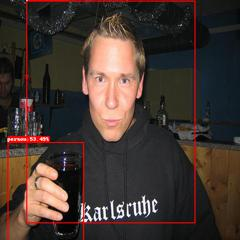

In [1]:

from PIL import Image, ImageDraw, ImageFont
import time
with open("/root/out.bin", "rb") as f:
    out = f.read()
    quantize_out_scale = 7.686170
    img_shape = (1, 3, 448, 448)
    net_out_shape = (14, 14, 5, 25)
    out = np.array(list(out), dtype=np.int8).reshape(net_out_shape).astype(np.float32) / quantize_out_scale
decoder = YoloDecoder(anchors = [1.3221, 1.73145, 3.19275, 4.00944, 5.05587, 8.09892, 9.47112, 4.84053, 11.2364, 10.0071])
t = time.time()
boxes, probs = decoder.run(out, 0.5)
print("decoder run time spent: {:.6f}s".format(time.time() - t))
print(boxes, probs)
class_names = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
img = Image.open("/root/input.jpg")
for i, box in enumerate(boxes):
    # center point rectangle to xmin, ymin, width, height
    box[0] = (box[0] - box[2]/2) * img.width
    box[1] = (box[1] - box[3]/2) * img.height
    box[2] *= img.width
    box[3] *= img.height
    class_id = probs[i].argmax()
    disp_str = "{}:{:.2f}%".format(class_names[class_id], probs[i][class_id]*100)
    draw_rectangle_with_title(img, box, disp_str)
    print("final box: {}, {}".format(box, disp_str))

# img.save("/root/out.jpg")
# img.show()

from maix import display
display.clear_output = False
display.show(img)
cccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccciiii